In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/study_1/data_full.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
data_list = []
for identifier, item in data.items():
    try:
        condition = item["log"]["condition"]
        date = item["date"]
        preference = item["log"]["preference"]
        ux_list = item["log"]["ux"]
        for i, ux in enumerate(ux_list, start=1):
            row = {"identifier": identifier, "condition": condition, "preference": preference, "date": date}
            for j in range(1, 11):
                key = f"ux{j}"
                if key in ux:
                    row[f"ux{j}_{i}"] = ux[key]
                else:
                    row[f"ux{j}_{i}"] = None
            data_list.append(row)
    except KeyError:
        print(f"Skipping identifier {identifier} due to missing keys or empty 'ux' list.")

# Create the DataFrame
df = pd.DataFrame(data_list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-10']

In [4]:
df.head(10)

,identifier,condition,preference,date,ux1_1,ux2_1,ux3_1,ux4_1,ux5_1,ux6_1,...,ux1_3,ux2_3,ux3_3,ux4_3,ux5_3,ux6_3,ux7_3,ux8_3,ux9_3,ux10_3
36,5705932755435520,1,cognitive,2023-08-11 17:15:38,2.0,2.0,3.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,5705932755435520,1,cognitive,2023-08-11 17:15:38,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,5770178285535232,1,baseline,2023-08-11 17:24:49,3.0,2.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,5770178285535232,1,baseline,2023-08-11 17:24:49,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,5746523350499328,0,cognitive,2023-08-11 17:26:21,0.0,3.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,5746523350499328,0,cognitive,2023-08-11 17:26:21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,5662792157757440,0,baseline,2023-08-11 17:26:22,0.0,2.0,2.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,5662792157757440,0,baseline,2023-08-11 17:26:22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,5672404563001344,0,cognitive,2023-08-11 17:29:49,0.0,3.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,5672404563001344,0,cognitive,2023-08-11 17:29:49,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = df.groupby(['identifier', 'condition', 'preference', 'date']).apply(lambda x: x.ffill().bfill())
df = df.drop_duplicates(subset=['identifier', 'condition', 'preference', 'date'])
df.reset_index(drop=True, inplace=True)

In [6]:
len(df['identifier'].value_counts())

121

In [7]:
# filtering the person who did not pay attention to anything
df = df[df['identifier'] != "5689069036109824"]

In [8]:
len(df['identifier'].value_counts())

120

### sus

System Usability Scale score:
- For each of the odd numbered questions, subtract 1 from the score.
- For each of the even numbered questions, subtract their value from 5.
- Take these new values which you have found, and add up the total score. Then multiply this by 2.5.

In [9]:
# sus_1
ux_cols_1 = ['ux1_1', 'ux2_1', 'ux3_1', 'ux4_1', 'ux5_1', 'ux6_1', 'ux7_1', 'ux8_1', 'ux9_1', 'ux10_1']
odd_ux_cols_1 = ux_cols_1[::2]  # odd
even_ux_cols_1 = ux_cols_1[1::2]  # even

df['sus_1'] = df[odd_ux_cols_1].apply(lambda x: x - 1).sum(axis=1) + df[even_ux_cols_1].apply(lambda x: 5 - x).sum(axis=1) # subtract 1 from odd-numbered questions and subtract from 5 for even-numbered questions
df['sus_1'] = df['sus_1'] * 2.5 # multiply the total score by 2.5

# sus_2
ux_cols_2 = ['ux1_2', 'ux2_2', 'ux3_2', 'ux4_2', 'ux5_2', 'ux6_2', 'ux7_2', 'ux8_2', 'ux9_2', 'ux10_2']
odd_ux_cols_2 = ux_cols_2[::2]  # odd
even_ux_cols_2 = ux_cols_2[1::2]  # even

df['sus_2'] = df[odd_ux_cols_2].apply(lambda x: x - 1).sum(axis=1) + df[even_ux_cols_2].apply(lambda x: 5 - x).sum(axis=1)
df['sus_2'] = df['sus_2'] * 2.5

In [10]:
df.head()

,identifier,condition,preference,date,ux1_1,ux2_1,ux3_1,ux4_1,ux5_1,ux6_1,...,ux3_3,ux4_3,ux5_3,ux6_3,ux7_3,ux8_3,ux9_3,ux10_3,sus_1,sus_2
0,5705932755435520,1,cognitive,2023-08-11 17:15:38,2.0,2.0,3.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.5,85.0
1,5770178285535232,1,baseline,2023-08-11 17:24:49,3.0,2.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.5,52.5
2,5746523350499328,0,cognitive,2023-08-11 17:26:21,0.0,3.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,27.5
3,5662792157757440,0,baseline,2023-08-11 17:26:22,0.0,2.0,2.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.5,57.5
4,5672404563001344,0,cognitive,2023-08-11 17:29:49,0.0,3.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,37.5


In [11]:
df['sus_cognitive'] = df.apply(lambda row: row['sus_1'] if row['condition'] == 0 else row['sus_2'], axis=1)
df['sus_baseline'] = df.apply(lambda row: row['sus_1'] if row['condition'] == 1 else row['sus_2'], axis=1)

df = df[['identifier', 'condition', 'preference', 'sus_cognitive', 'sus_baseline']]

### tests

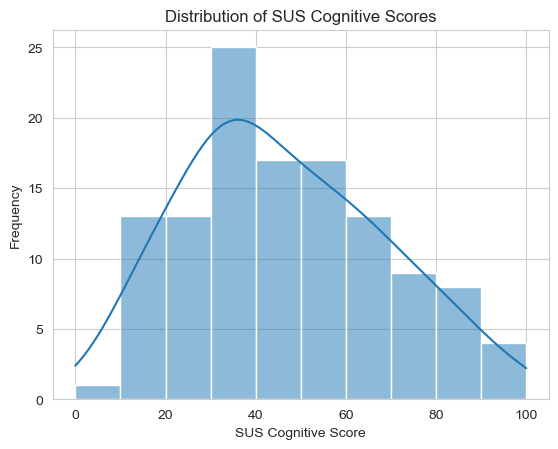

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='sus_cognitive', kde=True, bins=10)
plt.title('Distribution of SUS Cognitive Scores')
plt.xlabel('SUS Cognitive Score')
plt.ylabel('Frequency')
plt.show()

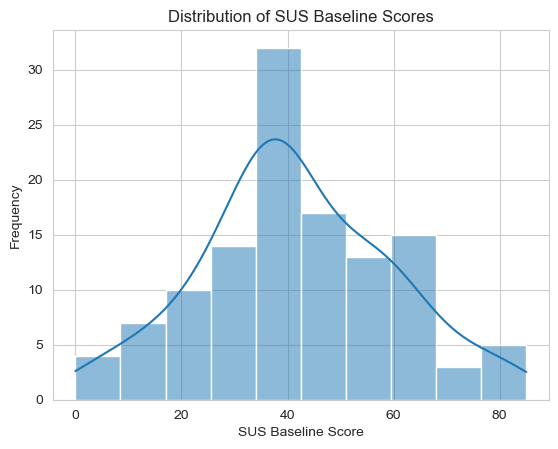

In [13]:
sns.histplot(data=df, x='sus_baseline', kde=True, bins=10)
plt.title('Distribution of SUS Baseline Scores')
plt.xlabel('SUS Baseline Score')
plt.ylabel('Frequency')
plt.show()

In [14]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(df['sus_cognitive'], df['sus_baseline'])

print("Paired t-test results:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    if t_stat > 0:
        print("Cognitive group has a significantly higher mean.")
    else:
        print("Baseline group has a significantly higher mean.")
else:
    print("No significant difference between groups.")

Paired t-test results:
t-statistic: 2.70515930353119
p-value: 0.0078294665559521
Cognitive group has a significantly higher mean.


In [15]:
df['sus_cognitive'].describe()

count    120.000000
mean      46.125000
std       22.325067
min        0.000000
25%       30.000000
50%       42.500000
75%       62.500000
max      100.000000
Name: sus_cognitive, dtype: float64

In [16]:
df['sus_baseline'].describe()

count    120.000000
mean      41.562500
std       18.193239
min        0.000000
25%       30.000000
50%       40.000000
75%       53.125000
max       85.000000
Name: sus_baseline, dtype: float64

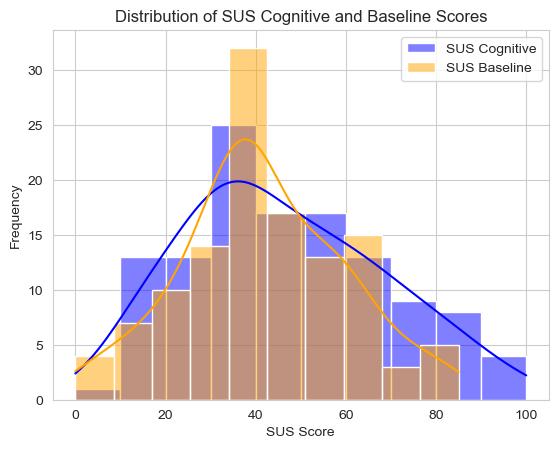

In [17]:
sns.histplot(data=df, x='sus_cognitive', kde=True, bins=10, color='blue', label='SUS Cognitive')
sns.histplot(data=df, x='sus_baseline', kde=True, bins=10, color='orange', label='SUS Baseline')
plt.title('Distribution of SUS Cognitive and Baseline Scores')
plt.xlabel('SUS Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

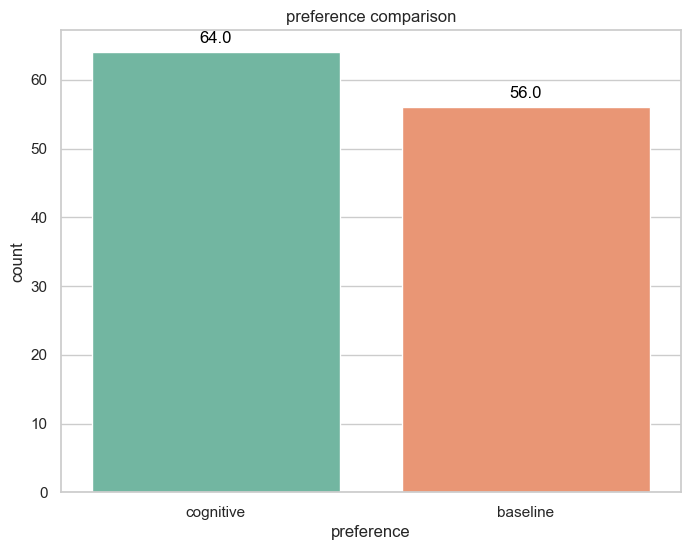

In [18]:
# preference
preference_counts = df['preference'].value_counts()

sns.set(style = "whitegrid")
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = 'preference', data = df, palette = 'Set2')
ax.set_title('preference comparison')
ax.set_xlabel('preference')
ax.set_ylabel('count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', fontsize = 12, color = 'black', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [19]:
df.to_csv('df_sus.csv', index = False)